# Programa del Taller Computacional 3

*Curso: Análisis de Fallas y Protección en Sistemas de Potencia IELE-41415*

*Universidad de los Andes*

Trabajo presentado por: 
- Andrés Enrique Avila Rojas
- Carlos Salomón Saenz Díaz
- Alberto Bérmudes Arias
- Valentina Reyes Martínez

This notebook presents the implementation of a virtual relay with a traveling wave differential protection function.

In [ ]:
# Import libraries that are necessaries
from scipy.signal import butter, filtfilt
import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
from scipy.io import loadmat
import cmath 
import pandas as pd
import plotly.express as px
from google.colab import widgets
from google.colab import output
import plotly.graph_objects as go

## Data Acquisition and Preprocessing

In [ ]:
#@markdown Load the files with the measurements from four terminals in ATPDraw in .mat format (v7). The order of the files should be: Bus 1, Bus 2, Bus 3, and finally Tap N. You have to select them at the same time.
from google.colab import files
uploaded = files.upload()

Saving Falla_AG_T15_0001ohm_T1.mat to Falla_AG_T15_0001ohm_T1 (3).mat
Saving Falla_AG_T15_0001ohm_T2.mat to Falla_AG_T15_0001ohm_T2 (3).mat
Saving Falla_AG_T15_0001ohm_T3.mat to Falla_AG_T15_0001ohm_T3 (2).mat
Saving Falla_AG_T15_0001ohm_TN.mat to Falla_AG_T15_0001ohm_TN (2).mat


In [ ]:
names = []
for fn in uploaded.keys():
    names.append(fn)

#@markdown # Inputs

#@markdown Add the necessaries inputs for this relay
Primary_CT = 2000 #@param {type:"number"}
Secundary_CT =  5#@param {type:"number"}
Primary_PT = 241000 #@param {type:"number"}
Secundary_PT =  110#@param {type:"number"}
#@markdown Number of samples per cycle
fs_user_cycle =  32#@param {type:"number"}

import io
mat_T1 = loadmat(io.BytesIO(uploaded[names[0]]))
mat_T2 = loadmat(io.BytesIO(uploaded[names[1]]))
mat_T3 = loadmat(io.BytesIO(uploaded[names[2]]))
mat_TN = loadmat(io.BytesIO(uploaded[names[3]]))

# RELACIÓN DE TRANSFORMADORES DE INTRUMENTACIÓN
#ratio_CT =2000/5 
ratio_CT = Primary_CT/Secundary_CT

In [ ]:
#@markdown # Digital Signal Processing

#@markdown This module shows the type of the fault.
# ---------------- Methods -----------------------------
# --- Subsampling
def subsampling(time,data,fs,fk,fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fs_comtrade is the sample rate from the comtrade file
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    N1 = fs_user_cycle
    fs_cycle = fs/fk
    N=np.int(fs_cycle)
    N_tot = np.int(len(data)/fs_cycle)
    new_data = [0]
    new_time = [0]
    for i in np.arange(N_tot):
        xi=data[i*N:i*N+N]
        ti=time[i*N:i*N+N]
        new_data[i*N1:i*N1+N1] = signal.resample(xi, N1)
        new_time[i*N1:i*N1+N1] = np.linspace(ti[0], ti[-1], N1, endpoint=False)
        
    return (new_time,new_data)

# --- Quantizer
def quantizer(data, quantizing_bits):
    # data is the vector with the signal
    # quantizing_bits is the number of bits for the converter
    # Quantizer - S&H and ADC
    quantizing_levels   = 2 ** quantizing_bits
    quantizing_step     = (np.max(data)-np.min(data)) / quantizing_levels
    quantizing_signal   = np.round (data / quantizing_step) * quantizing_step;
    
    return quantizing_signal

# --- Discrete Fourier Transform
def DFT(time, data, fk, fs_user_cycle):
    # time is the vector of time
    # data is the vector with the signal
    # fk is the frequency of the system
    # fs_user_cycle is the sample rate given by user
    
    N=np.int(fs_user_cycle)
    N_tot = len(data)-N
    Xc = [0]*N_tot
    Xs = [0]*N_tot
    t = [0]*N_tot
    
    # Ciclo para el ventaneo
    for i in np.arange(N_tot):
        xi=data[i:i+N]
        t[i]=time[i]
        Xc_sum = 0
        Xs_sum = 0
        # Ciclo para el filtro coseno
        for k in np.arange(N):
            Xc_temp=xi[k]*np.cos(2*np.pi*k/(N))
            Xc_sum=Xc_sum+Xc_temp
            Xs_temp=xi[k]*np.sin(2*np.pi*k/(N))
            Xs_sum=Xs_sum+Xs_temp
            
        Xc[i]= 2/(N*np.sqrt(2))*Xc_sum
        Xs[i]= -2/(N*np.sqrt(2))* Xs_sum
        
    return t, Xc, Xs

# ---------------- Data -----------------------------
# Reading time vector:
time = mat_T1['t'] #Se conoce que todos los archivos vendrán con este vector incluido

N = len(time)
fs = np.int(np.ceil(len(time)/time[-1])-4)

# Line frequency in Hz
fk = 60 # It can be set automatically

# Reading voltaje and currents
voltages_bus1 = np.empty(([len(time),3]))
currents_bus1 = np.empty(([len(time),3]))

col=0
for i in ['a','b','c']:
    voltages_bus1[:,col] = mat_T1['vVt1'+i].ravel()
    currents_bus1[:,col] = mat_T1['iCt1'+i].ravel()
    col=col+1

# ---------------- Subsampling -----------------------------
# Subsampling voltaje and currents
N_tot = np.int(N*fk/fs)*fs_user_cycle
V_bus1_sub = np.empty(([N_tot,3]))
I_bus1_sub = np.empty(([N_tot,3]))
time_sub = np.empty(([N_tot,6]))
for i in np.arange(6):
    if i<3:
        time_sub[:,i], V_bus1_sub[:,i] = subsampling(time,voltages_bus1[:,i],fs,fk,fs_user_cycle)
    else:
        time_sub[:,i], I_bus1_sub[:,i-3] = subsampling(time,currents_bus1[:,i-3],fs,fk,fs_user_cycle)

# ---------------- ADC -----------------------------
quantizing_bits_V = 12 # Valor típico: 12 (Voltaje)
quantizing_bits_I = 16 # Valor típico: 16 (Corriente)
dig_V_bus1_sub = np.empty(([N_tot,3]))
dig_I_bus1_sub = np.empty(([N_tot,3]))
dig_V_bus2_sub = np.empty(([N_tot,3]))
dig_I_bus2_sub = np.empty(([N_tot,3]))
for i in np.arange(6):
    if i<3:
        dig_V_bus1_sub[:,i] = quantizer(V_bus1_sub[:,i], quantizing_bits_V)
    else:
        dig_I_bus1_sub[:,i-3] = quantizer(I_bus1_sub[:,i-3], quantizing_bits_I)

# ---------------- DFT -----------------------------
N_tot_DFT = N_tot-fs_user_cycle
Xc_bus1_V = np.empty(([N_tot_DFT,3]))
Xs_bus1_V = np.empty(([N_tot_DFT,3]))
Xc_bus1_I = np.empty(([N_tot_DFT,3]))
Xs_bus1_I = np.empty(([N_tot_DFT,3]))
X_bus1_V = np.empty(([N_tot_DFT,3]))
Y_bus1_V = np.empty(([N_tot_DFT,3]))
X_bus1_I = np.empty(([N_tot_DFT,3]))
Y_bus1_I = np.empty(([N_tot_DFT,3]))
t = np.empty(([N_tot_DFT,6]))

for i in np.arange(6):
    if i<3:
        #BUS1
        t[:,i], Xc_bus1_V[:,i], Xs_bus1_V[:,i] = DFT(time_sub[:,i], dig_V_bus1_sub[:,i], fk, fs_user_cycle)
        for j in range(len(Xc_bus1_V)):
            z_bus1_V = complex(Xc_bus1_V[j,i],Xs_bus1_V[j,i])
            X_bus1_V[j,i], Y_bus1_V[j,i] = cmath.polar(z_bus1_V)
            Y_bus1_V[j,i] = (Y_bus1_V[j,i])*180/np.pi
            if Y_bus1_V[j,i] < 0:
                Y_bus1_V[j,i] = 360 + Y_bus1_V[j,i]
    else:
        #BUS1
        t[:,i], Xc_bus1_I[:,i-3], Xs_bus1_I[:,i-3] = DFT(time_sub[:,i], dig_I_bus1_sub[:,i-3], fk, fs_user_cycle)
        for j in range(len(Xc_bus1_I)):
            z_bus1_I = complex(Xc_bus1_I[j,i-3],Xs_bus1_I[j,i-3])
            X_bus1_I[j,i-3], Y_bus1_I[j,i-3] = cmath.polar(z_bus1_I)
            Y_bus1_I[j,i-3] = (Y_bus1_I[j,i-3])*180/np.pi
            if Y_bus1_I[j,i-3] < 0:
                Y_bus1_I[j,i-3] = 360 + Y_bus1_I[j,i-3]

# ---------------- Fault Detection -----------------------------
pos_tf1=0
V_nom = 115/np.sqrt(3)
p = 0.8 #Criterio de comparación
for i in range(len(X_bus1_V)):    
    phA = X_bus1_V[i,0]
    phB = X_bus1_V[i,1]
    phC = X_bus1_V[i,2]
    if phA < V_nom*p or phB < V_nom*p or phC < V_nom*p:
        pos_tf1=i
        break

pos_tf = pos_tf1+fs_user_cycle*4 # Se esperan 4 ciclos para determinar
# ---------------- Fault Vector -----------------------------
ph_falla = np.empty(([1,6]), dtype=complex)
ph = ['A','B','C']
for i in range(len(ph)):
    ph_falla[0,i] = complex(Xc_bus1_V[pos_tf,i],Xs_bus1_V[pos_tf,i])
    ph_falla[0,i+3] = complex(Xc_bus1_I[pos_tf,i],Xs_bus1_I[pos_tf,i])

# ---------------- Sequence components calculation -----------------------------
def seq_general(ph):
    # Se usan las fases en valores rectangulares
    phA = ph[0]
    phB = ph[1]
    phC = ph[2]
    a = -0.5 + (np.sqrt(3)/2)*1j
    s0=(phA+phB+phC)/3
    s1=(phA+a*phB+a*a*phC)/3
    s2=(phA+a*a*phB+a*phC)/3
    #s = [s0, s1, s2]
    return s0, s1, s2

def seq_pos(s1):
    a = -0.5 + (np.sqrt(3)/2)*1j
    phA1 = s1
    phB1 = a*a*s1
    phC1 = a*s1
    ph = [phA1, phB1, phC1]
    return ph
    
def seq_neg(s2):
    a = -0.5 + (np.sqrt(3)/2)*1j
    phA2 = s2
    phB2 = a*s2
    phC2 = a*a*s2
    ph = [phA2, phB2, phC2]
    return ph

# ---------------- Criterion for phase selection -----------------------------
# ------ Positive-negative component comparison
def pos_neg():
    etiqueta_pos_neg = [{'AG'},{'AB','ABG'},{'BG'},{'BC','BCG'},{'CG'},{'AC','ACG'}]

    grupos_pos_neg = [set()]*12
    fallas_pos_neg = np.empty(([12,2]))
    c = 0
    for i in range(len(fallas_pos_neg)):
        if (i%2)==0:
            grupos_pos_neg[i] = etiqueta_pos_neg[c] 
            if i==0:
                fallas_pos_neg[i,0:2] = [340,20]
            else:
                fallas_pos_neg[i,0:2] = [fallas_pos_neg[i-1,1],fallas_pos_neg[i-1,1]+40]
            c=c+1
        else:
            fallas_pos_neg[i,0:2] = [fallas_pos_neg[i-1,1],fallas_pos_neg[i-1,1]+20]
            if c<len(etiqueta_pos_neg):
                grupos_pos_neg[i] = etiqueta_pos_neg[c].union(grupos_pos_neg[i-1])
            else:
                grupos_pos_neg[i] = grupos_pos_neg[i-1].union(etiqueta_pos_neg[0])
    return grupos_pos_neg, fallas_pos_neg

# ------ Cero-negative component comparison
def cero_neg():
    etiqueta_cero_neg = [{'AG','BCG'},{'CG','ABG'},{'BG','ACG'}]

    grupos_cero_neg = [set()]*6
    fallas_cero_neg = np.empty(([6,2]))
    c = 0
    for i in range(len(fallas_cero_neg)):
        if (i%2)==0:
            grupos_cero_neg[i] = etiqueta_cero_neg[c] 
            if i==0:
                fallas_cero_neg[i,0:2] = [315,45]
            else:
                fallas_cero_neg[i,0:2] = [fallas_cero_neg[i-1,1],fallas_cero_neg[i-1,1]+90]
            c=c+1
        else:
            fallas_cero_neg[i,0:2] = [fallas_cero_neg[i-1,1],fallas_cero_neg[i-1,1]+30]
            if c<len(etiqueta_cero_neg):
                grupos_cero_neg[i] = etiqueta_cero_neg[c].union(grupos_cero_neg[i-1])
            else:
                grupos_cero_neg[i] = grupos_cero_neg[i-1].union(etiqueta_cero_neg[0])
    return grupos_cero_neg, fallas_cero_neg

# ---------------- Fault type selection -----------------------------
def tipo_falla(s0,s1,s2):
    r0, th0 = cmath.polar(s0)
    r1, th1 = cmath.polar(s1)
    r2, th2 = cmath.polar(s2)
    
    grupos_pos_neg, fallas_pos_neg = pos_neg()
    grupos_cero_neg, fallas_cero_neg = cero_neg()
    if r2 < 0.25:
        type_f={'ABC'}
    else:
        if r0 > 0.02:
            grupo_mo = {'AG','BG','CG'}
            # Verificación cero-negativa
            th2_off = th2 - th0
            th0_off = th0 - th0
            des0 = (th2_off - th0_off)*180/np.pi
            if des0<0: des0 = 360+des0
            for i in range(len(fallas_cero_neg)):
                if des0>340 or des0<=20:
                    sel1=grupos_cero_neg[0]
                elif i!=0 and des0>fallas_cero_neg[i,0] and des0<=fallas_cero_neg[i,1]:
                    sel1=grupos_cero_neg[i]
            # Verificacion positiva-negativa
            th2_off = th2 - th1
            th1_off = th1 - th1
            des1 = (th2_off-th1_off)*180/np.pi
            if des1<0: des1 = 360+des1
            for i in range(len(fallas_pos_neg)):
                if des1>340 or des1<=20:
                    sel2=grupos_pos_neg[0]
                elif i!=0 and des1>fallas_pos_neg[i,0] and des1<=fallas_pos_neg[i,1]:
                    sel2=grupos_pos_neg[i]
            type_f = sel1.intersection(sel2)
            if type_f == set():
                type_f = sel1.intersection(grupo_mo)
        else:
            grupo_bi = {'AB','BC','AC'}
            th2_off = th2 - th1
            th1_off = th1 - th1
            des1 = (th2_off-th1_off)*180/np.pi
            if des1<0: des1 = 360+des1
            for i in range(len(fallas_pos_neg)):
                if des1>340 or des1<=20:
                    sel=(grupos_pos_neg[0])
                elif i!=0 and des1>fallas_pos_neg[i,0] and des1<=fallas_pos_neg[i,1]:
                    sel=(grupos_pos_neg[i])
            type_f = sel.intersection(grupo_bi)
    return type_f

# ---------------- Showing the type of fault -----------------------------
ph_I = ph_falla[0,3:6]
s0_I,s1_I,s2_I = seq_general(ph_I)
tipo = tipo_falla(s0_I,s1_I,s2_I)
print('The fault is {}'.format(*tipo))

The fault is AG


Record has 300001 samples
Sampling rate is 1000000 samples/sec.


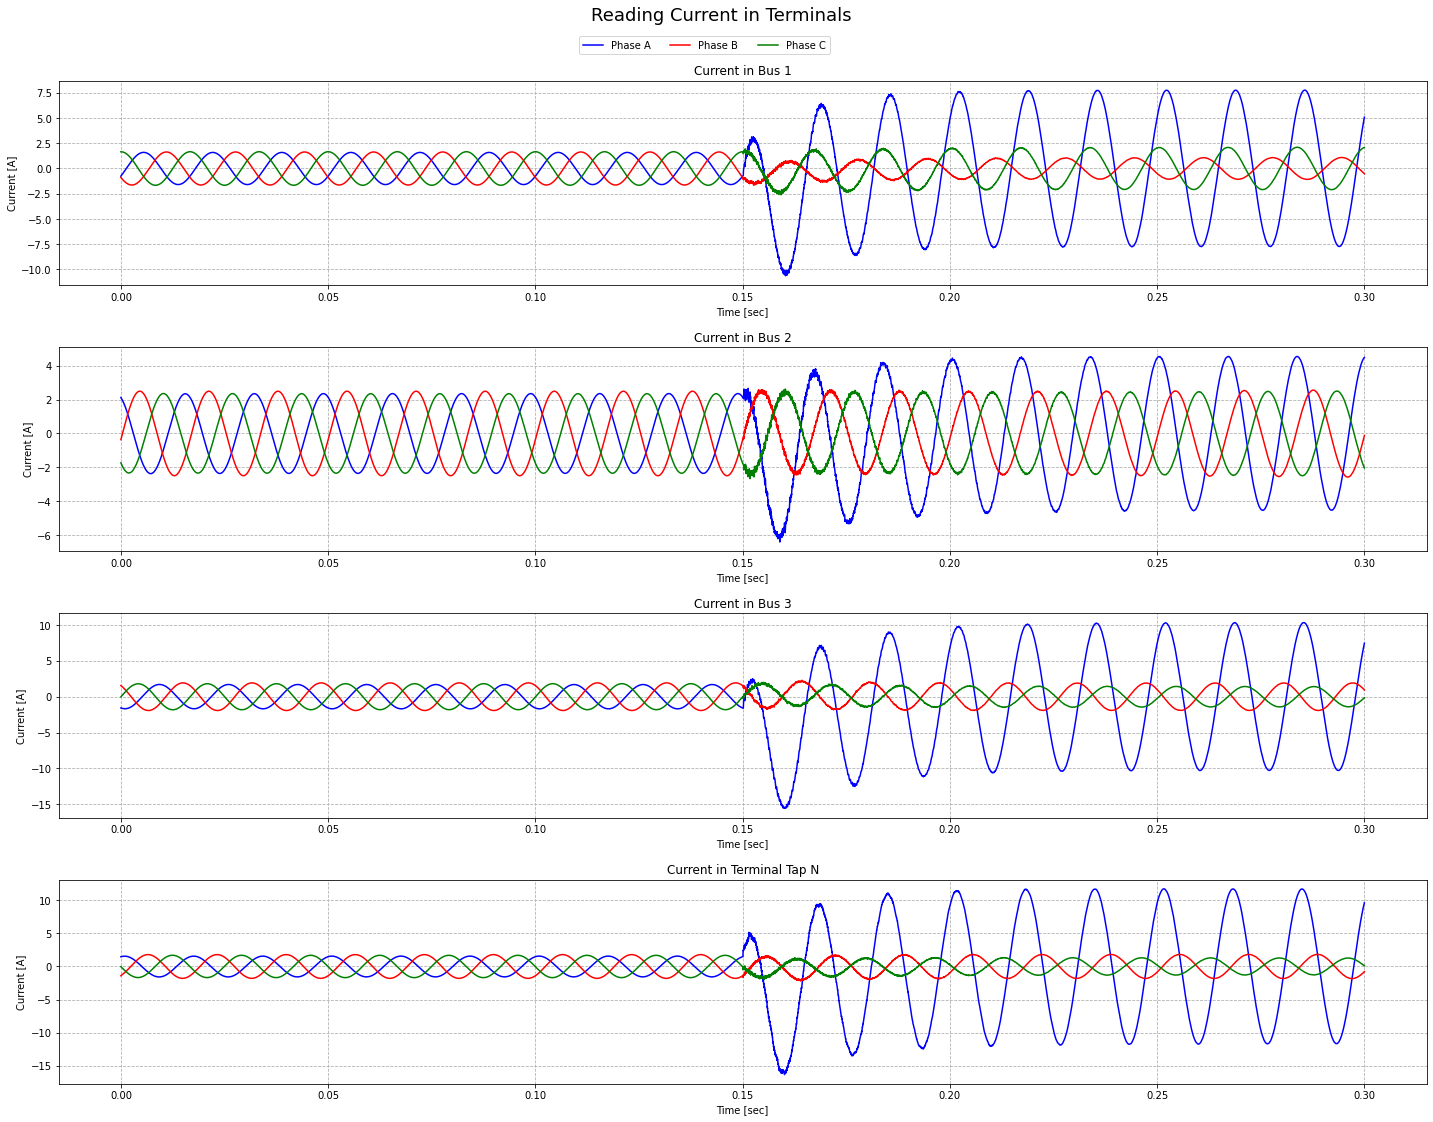

In [ ]:
#@markdown # Signal of current from ATPDraw in four terminals
# Reading time vector:
time = mat_T1['t'] #Se conoce que todos los archivos vendrán con este vector incluido

N = len(time)
fs = np.int(np.ceil(len(time)/time[-1])-4)

print('Record has {} samples'.format(N))
print('Sampling rate is {} samples/sec.'.format(fs))


# Line frequency in Hz
fk = 60 # It can be set automatically


# Reading  currents

currents_bus1 = np.empty(([len(time),3]))
currents_bus2 = np.empty(([len(time),3]))
currents_bus3 = np.empty(([len(time),3]))
currents_tapN = np.empty(([len(time),3]))

col=0
for i in ['a','b','c']:    
    currents_bus1[:,col] = mat_T1['iCt1'+i].ravel()
    currents_bus2[:,col] = mat_T2['iCt2'+i].ravel()
    currents_bus3[:,col] = mat_T3['iCt3'+i].ravel()
    currents_tapN[:,col] = mat_TN['iCtn'+i].ravel()
    col += 1
    
#measures = [voltages_bus1,currents_bus1,voltages_bus2,currents_bus2]
#print(N_tot)
measures = [currents_bus1,currents_bus2,currents_bus3,currents_tapN]
            
f, axarr = plt.subplots(4,1, figsize =(20, 15))
f.suptitle('Reading Current in Terminals', y=1.04, fontsize=18)
labels = ['Phase A', 'Phase B', 'Phase C']

n_bus=1
for i in range(len(measures)):
        p2 = i
        if n_bus==4:
          axarr[p2].set_title(('Current in Terminal Tap N'))
        else:
          axarr[p2].set_title(('Current in Bus '+str(n_bus)))
        
        axarr[p2].set_ylabel('Current [A]')        
        
        axarr[p2].set_xlabel('Time [sec]')
        axarr[p2].plot(time, measures[i][:,0], 'b-', label='Phase A')
        axarr[p2].plot(time, measures[i][:,1], 'r-', label='Phase B')
        axarr[p2].plot(time, measures[i][:,2], 'g-', label='Phase C')
        axarr[p2].grid(linestyle='--')
        
        n_bus=n_bus+1
        
f.legend(axarr[0].get_lines(), labels, ncol=3, bbox_to_anchor=(0.58, 1.01))
f.tight_layout(pad=1.5)

In [ ]:
def butter_highpass(cutoff, fs, order):
    """
    Design a highpass filter.

    Args:
        - cutoff (float) : the cutoff frequency of the filter.
        - fs     (float) : the sampling rate.
        - order    (int) : order of the filter, by default defined to 5.
    """
    # calculate the Nyquist frequency
    nyq = 0.5 * fs

    # design filter
    high = cutoff / nyq
    b, a = butter(order, high, btype='high', analog=False)

    # returns the filter coefficients: numerator and denominator
    return b, a

#@markdown # High Pass Filter

#@markdown Select the cutoff for the high pass digital filter
cutoff = 20e3 #@param {type:"number"}
b, a = butter_highpass(cutoff, fs, order=1)

## Filtered Signal

In [ ]:
#@markdown **Bus 1**
HPF_1A = signal.lfilter(b, a, currents_bus1[:,0])*ratio_CT
HPF_1B = signal.lfilter(b, a, currents_bus1[:,1])*ratio_CT
HPF_1C = signal.lfilter(b, a, currents_bus1[:,2])*ratio_CT
tb = widgets.TabBar(['All','Phase A', 'Phase B', 'Phase C'], location='top')
with tb.output_to(0):  
  plt.figure(figsize=(19, 6))
  plt.plot(time,HPF_1A)
  plt.plot(time,HPF_1B)
  plt.plot(time,HPF_1C)
  plt.ylabel('Current [A]')
  plt.xlabel('Time [sec]')
  plt.grid(linestyle='-')
  plt.show()
with tb.output_to(1):
  fig_HPF1a = go.Figure()
  fig_HPF1a.add_trace(go.Scatter(x=time[:,0], y=HPF_1A))
  fig_HPF1a.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF1a.show()
# Note you can access tab by its name (if they are unique), or
# by its index.
with tb.output_to(2):
  fig_HPF1b = go.Figure()
  fig_HPF1b.add_trace(go.Scatter(x=time[:,0], y=HPF_1B))
  fig_HPF1b.update_traces(line_color='red')
  fig_HPF1b.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF1b.show()
with tb.output_to(3):
  fig_HPF1c = go.Figure()
  fig_HPF1c.add_trace(go.Scatter(x=time[:,0], y=HPF_1C))
  fig_HPF1c.update_traces(line_color='green')
  fig_HPF1c.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF1c.show()

In [ ]:
#@markdown **Bus 2**
HPF_2A = signal.lfilter(b, a, currents_bus2[:,0])*ratio_CT
HPF_2B = signal.lfilter(b, a, currents_bus2[:,1])*ratio_CT
HPF_2C = signal.lfilter(b, a, currents_bus2[:,2])*ratio_CT
tb = widgets.TabBar(['All','Phase A', 'Phase B', 'Phase C'], location='top')
with tb.output_to(0):
  plt.figure(figsize=(19, 6))
  plt.plot(time,HPF_2A)
  plt.plot(time,HPF_2B)
  plt.plot(time,HPF_2C)
  plt.ylabel('Current [A]')
  plt.xlabel('Time[sec]')
  plt.grid(linestyle='-')
  plt.show()
with tb.output_to(1):
  fig_HPF2a = go.Figure()
  fig_HPF2a.add_trace(go.Scatter(x=time[:,0], y=HPF_2A))
  fig_HPF2a.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF2a.show()
# Note you can access tab by its name (if they are unique), or
# by its index.
with tb.output_to(2):
  fig_HPF2b = go.Figure()
  fig_HPF2b.add_trace(go.Scatter(x=time[:,0], y=HPF_2B))
  fig_HPF2b.update_traces(line_color='red')
  fig_HPF2b.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF2b.show()
with tb.output_to(3):
  fig_HPF2c = go.Figure()
  fig_HPF2c.add_trace(go.Scatter(x=time[:,0], y=HPF_2C))
  fig_HPF2c.update_traces(line_color='green')
  fig_HPF2c.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF2c.show()

In [ ]:
#@markdown **Bus 3**
HPF_3A = signal.lfilter(b, a, currents_bus3[:,0])*ratio_CT
HPF_3B = signal.lfilter(b, a, currents_bus3[:,1])*ratio_CT
HPF_3C = signal.lfilter(b, a, currents_bus3[:,2])*ratio_CT
tb = widgets.TabBar(['All','Phase A', 'Phase B', 'Phase C'], location='top')
with tb.output_to(0):
  plt.figure(figsize=(19, 6))
  plt.plot(time,HPF_3A)
  plt.plot(time,HPF_3B)
  plt.plot(time,HPF_3C)
  plt.ylabel('Current [A]')
  plt.xlabel('Time[sec]')
  plt.grid(linestyle='-')
  plt.show()
with tb.output_to(1):
  fig_HPF3a = go.Figure()
  fig_HPF3a.add_trace(go.Scatter(x=time[:,0], y=HPF_3A))
  fig_HPF3a.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF3a.show()
# Note you can access tab by its name (if they are unique), or
# by its index.
with tb.output_to(2):
  fig_HPF3b = go.Figure()
  fig_HPF3b.add_trace(go.Scatter(x=time[:,0], y=HPF_3B))
  fig_HPF3b.update_traces(line_color='red')
  fig_HPF3b.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF3b.show()
with tb.output_to(3):
  fig_HPF3c = go.Figure()
  fig_HPF3c.add_trace(go.Scatter(x=time[:,0], y=HPF_3C))
  fig_HPF3c.update_traces(line_color='green')
  fig_HPF3c.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF3c.show()

In [ ]:
#@markdown **Tap N**
HPF_NA = signal.lfilter(b, a, currents_tapN[:,0])*ratio_CT
HPF_NB = signal.lfilter(b, a, currents_tapN[:,1])*ratio_CT
HPF_NC = signal.lfilter(b, a, currents_tapN[:,2])*ratio_CT
tb = widgets.TabBar(['All','Phase A', 'Phase B', 'Phase C'], location='top')
with tb.output_to(0):
  plt.figure(figsize=(19, 6))
  plt.plot(time,HPF_NA)
  plt.plot(time,HPF_NB)
  plt.plot(time,HPF_NC)
  plt.ylabel('Current [A]')
  plt.xlabel('Time[sec]')
  plt.grid(linestyle='-')
  plt.show()
with tb.output_to(1):
  fig_HPF3a = go.Figure()
  fig_HPF3a.add_trace(go.Scatter(x=time[:,0], y=HPF_NA))
  fig_HPF3a.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF3a.show()
# Note you can access tab by its name (if they are unique), or
# by its index.
with tb.output_to(2):
  fig_HPF3b = go.Figure()
  fig_HPF3b.add_trace(go.Scatter(x=time[:,0], y=HPF_NB))
  fig_HPF3b.update_traces(line_color='red')
  fig_HPF3b.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF3b.show()
with tb.output_to(3):
  fig_HPF3c = go.Figure()
  fig_HPF3c.add_trace(go.Scatter(x=time[:,0], y=HPF_NC))
  fig_HPF3c.update_traces(line_color='green')
  fig_HPF3c.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_HPF3c.show()

## Clarke Transform

In [ ]:
#@title Run the Clarke Transform
def clarke_A(ABC):
  M=np.array([[2,-1,-1],[0,np.sqrt(3),-np.sqrt(3)],[1,1,1]])
  C = 1/3*M
  tca = np.matmul(C,ABC)
  return tca[0]

def clarke_B(ABC):
  M=np.array([[-1,2,-1],[np.sqrt(3),0,-np.sqrt(3)],[1,1,1]])
  C = 1/3*M
  tcb = np.matmul(C,ABC)
  return tcb[0]

def clarke_C(ABC):
  M=np.array([[-1,-1,2],[np.sqrt(3),-np.sqrt(3),0],[1,1,1]])
  C = 1/3*M
  tcc = np.matmul(C,ABC)
  return tcc[0]

In [ ]:
#@title # Alpha Component for each terminal
fallas_B = [{'BG'},{'BC'},{'BCG'}]
fallas_C = [{'CG'}]

clarke_Bus1 = []
clarke_Bus2 = []
clarke_Bus3 = []
clarke_TapN = []

if tipo == fallas_C:
  for i in range(len(HPF_1A)):
    ABC_1 = [HPF_1A[i],HPF_1B[i],HPF_1C[i]]
    ABC_2 = [HPF_2A[i],HPF_2B[i],HPF_2C[i]]
    ABC_3 = [HPF_3A[i],HPF_3B[i],HPF_3C[i]]
    ABC_N = [HPF_NA[i],HPF_NB[i],HPF_NC[i]]
    clarke_Bus1.append(clarke_C(ABC_1))
    clarke_Bus2.append(clarke_C(ABC_2))
    clarke_Bus3.append(clarke_C(ABC_3))
    clarke_TapN.append(clarke_C(ABC_N))
else:
  en_B = 0
  for i in fallas_B:
    if tipo == i:
      en_B = 1
      break
  if en_B == 1:
    for i in range(len(HPF_1A)):
      ABC_1 = [HPF_1A[i],HPF_1B[i],HPF_1C[i]]
      ABC_2 = [HPF_2A[i],HPF_2B[i],HPF_2C[i]]
      ABC_3 = [HPF_3A[i],HPF_3B[i],HPF_3C[i]]
      ABC_N = [HPF_NA[i],HPF_NB[i],HPF_NC[i]]
      clarke_Bus1.append(clarke_B(ABC_1))
      clarke_Bus2.append(clarke_B(ABC_2))
      clarke_Bus3.append(clarke_B(ABC_3))
      clarke_TapN.append(clarke_B(ABC_N))
  else:
    for i in range(len(HPF_1A)):
      ABC_1 = [HPF_1A[i],HPF_1B[i],HPF_1C[i]]
      ABC_2 = [HPF_2A[i],HPF_2B[i],HPF_2C[i]]
      ABC_3 = [HPF_3A[i],HPF_3B[i],HPF_3C[i]]
      ABC_N = [HPF_NA[i],HPF_NB[i],HPF_NC[i]]
      clarke_Bus1.append(clarke_A(ABC_1))
      clarke_Bus2.append(clarke_A(ABC_2))
      clarke_Bus3.append(clarke_A(ABC_3))
      clarke_TapN.append(clarke_A(ABC_N))


# Plotting
tb = widgets.TabBar(['Bus 1','Bus 2', 'Bus 3', 'Tap N'], location='top')
with tb.output_to(0):
  fig_clarke1 = go.Figure()
  fig_clarke1.add_trace(go.Scatter(x=time[:,0], y=clarke_Bus1))
  fig_clarke1.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_clarke1.show()
with tb.output_to(1):
  fig_clarke2 = go.Figure()
  fig_clarke2.add_trace(go.Scatter(x=time[:,0], y=clarke_Bus2))
  fig_clarke2.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_clarke2.show()
# Note you can access tab by its name (if they are unique), or
# by its index.
with tb.output_to(2):
  fig_clarke3 = go.Figure()
  fig_clarke3.add_trace(go.Scatter(x=time[:,0], y=clarke_Bus3))
  fig_clarke3.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_clarke3.show()
with tb.output_to(3):
  fig_clarkeN = go.Figure()
  fig_clarkeN.add_trace(go.Scatter(x=time[:,0], y=clarke_TapN))
  fig_clarkeN.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_clarkeN.show()

In [ ]:
def polarization(clarke_vector, time):
  val = []
  no_cero = 0
  for i in range(len(time)):
    if time[i]>0.05 and np.abs(clarke_vector[i]) > 10:
      no_cero += 1
      val.append(clarke_vector[i])
    else:
      if no_cero != 0:
        break

  pos = val.index(max(np.abs(val)))
  if val[pos]<0:
    pol = -1
  else: 
    pol = 1

  return pol


In [ ]:
pol_1 = polarization(clarke_Bus1, time)
pol_2 = polarization(clarke_Bus2, time)
pol_3 = polarization(clarke_Bus3, time)
pol_N = polarization(clarke_TapN, time)

if pol_1 == pol_N and pol_2 == pol_N and pol_3 == pol_N:
  print('Es interna!')
else:
  print('ayñññ según esto es externa :c')

Es interna!


In [ ]:
val = []
no_cero = 0
for i in range(len(time)):
  if time[i]>0.05 and np.abs(clarke_TapN[i]) > 10:
    no_cero += 1
    val.append(clarke_TapN[i])
  else:
    if no_cero != 0:
      print('entro')
      print(time[i])
      break

pos = val.index(max(np.abs(val)))
if val[pos]<0:
  print('es negativo')
else: print('es positivo')

entro
[0.15010799]
es positivo
27
272.19727549626293
1


272.19727549626293

## Differentiator Smoother

In [ ]:
def smooth_diff(n):
  #n: filter length (positive integer larger no less than 2)
  if n>=2 and np.floor(n)==np.ceil(n):
    if n%2==1: #is odd
        m=int(np.fix((n-1)/2))
        h=[-np.ones([1,m])/m/(m+1), np.zeros([1,1]), np.ones([1,m])/m/(m+1)]
    else: #is even
        m=int(np.fix(n/2))
        h=[-np.ones([1,m])/m**2, np.ones([1,m])/m**2]
    hnew = []
    for i in range(len(h)):
      for j in range(h[i].shape[1]):
        hnew.append(h[i][0,j])
    hnew = np.array(hnew)
  else:    
    print('The input parameter (n) should be a positive integer larger no less than 2.')
  return hnew

In [ ]:
T_DS = 20e-6 # According to SEL Ultra-High-Speed Transmission Line Relay Traveling-Wave Fault Locator High-Resolution Event Recorder 2017. 
n = int(T_DS*fs)
h = smooth_diff(n)
DS_bus1 = signal.filtfilt(h, 1, clarke_Bus1)
for i in range(len(DS_bus1)):
  if DS_bus1[i]<0: DS_bus1[i] = 0

DS_bus2 = signal.filtfilt(h, 1, clarke_Bus2)
for i in range(len(DS_bus2)):
  if DS_bus2[i]<0: DS_bus2[i] = 0

DS_bus3 = signal.filtfilt(h, 1, clarke_Bus3)
for i in range(len(DS_bus3)):
  if DS_bus3[i]<0: DS_bus3[i] = 0

DS_TapN = signal.filtfilt(h, 1, clarke_TapN)
for i in range(len(DS_TapN)):
  if DS_TapN[i]<0: DS_TapN[i] = 0

# Plotting
tb = widgets.TabBar(['Bus 1','Bus 2', 'Bus 3', 'Tap N'], location='top')
with tb.output_to(0):
  fig_DS1 = go.Figure()
  fig_DS1.add_trace(go.Scatter(x=time[:,0], y=DS_bus1))
  fig_DS1.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_DS1.show()
with tb.output_to(1):
  fig_DS2 = go.Figure()
  fig_DS2.add_trace(go.Scatter(x=time[:,0], y=DS_bus2))
  fig_DS2.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_DS2.show()
# Note you can access tab by its name (if they are unique), or
# by its index.
with tb.output_to(2):
  fig_DS3 = go.Figure()
  fig_DS3.add_trace(go.Scatter(x=time[:,0], y=DS_bus3))
  fig_DS3.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_DS3.show()
with tb.output_to(3):
  fig_DSN = go.Figure()
  fig_DSN.add_trace(go.Scatter(x=time[:,0], y=DS_TapN))
  fig_DSN.update_layout(
  xaxis_title="Time [sec]",
  yaxis_title="Current [A]")
  fig_DSN.show()

In [ ]:
def define_arrival_time(DS_vector, time):
  val = []
  arrival_t = []
  no_cero = 0
  for i in range(len(time)):
    if time[i]>0.05 and np.abs(DS_vector[i]) > 0.02:
      no_cero += 1
      val.append(DS_vector[i])
      arrival_t.append(time[i])
    else:
      if no_cero != 0:
        break

  pos = val.index(max(val))
  return arrival_t[pos]

In [ ]:
arrival_time_1 = define_arrival_time(DS_bus1, time)
arrival_time_2 = define_arrival_time(DS_bus2, time)
arrival_time_3 = define_arrival_time(DS_bus3, time)
arrival_time_N = define_arrival_time(DS_TapN, time)

print('El tiempo de llegada en 1 es {}'.format(arrival_time_1))
print('El tiempo de llegada en 2 es {}'.format(arrival_time_2))
print('El tiempo de llegada en 3 es {}'.format(arrival_time_3))
print('El tiempo de llegada en N es {}'.format(arrival_time_N))

El tiempo de llegada en 1 es [0.150166]
El tiempo de llegada en 2 es [0.15024699]
El tiempo de llegada en 3 es [0.15016299]
El tiempo de llegada en N es [0.150085]


In [ ]:
val = []
arrival_t = []
no_cero = 0
for i in range(len(time)):
  if time[i]>0.05 and np.abs(DS_TapN[i]) > 0.02:
    no_cero += 1
    val.append(DS_TapN[i])
    arrival_t.append(time[i])
  else:
    if no_cero != 0:
      print('entro')
      print(time[i])
      break

pos = val.index(max(val))
print('el tiempo es ', arrival_t[pos])

entro
[0.150094]
el tiempo es  [0.150085]


In [ ]:
np.abs(-1)

1

In [ ]:
for i in range(len(time)):
  if t[pos_tf,0]==time[i]:
    print('existe')

## Determining Arrival Time